In [63]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import sys
sys.path.insert(0, '../')
import pandas as pd
import talib as ta
import numpy as np
from config import key_id, secret_key
from datetime import datetime 
from scipy import signal
import scipy
from pandas import DataFrame

In [5]:
#use modin for faster processing
#import modin.pandas as pd

In [6]:
data=pd.read_csv('data/JACK.csv')

In [7]:
type(data.index[0])

int

In [8]:
data2=data.set_index('timestamp').sort_index(ascending=False)

# Cleaning data


In [9]:
#converting timestamp row to timestamp type
data2.index=pd.to_datetime(data2.index, utc=True)

In [10]:
# Create a DatetimeIndex and assign it to the dataframe.
data2.index = pd.DatetimeIndex(data2.index)

In [11]:
#Count ticks on unique days
day_tick_cnt = data2.index.normalize() \
                     .value_counts() \
                     .to_frame().reset_index()

#Keep days that have ticks greater than 300
day_list=day_tick_cnt[~(day_tick_cnt['timestamp'] >= 240)]

In [12]:
len(day_tick_cnt)- len(day_list)

2690

In [13]:
#create date
data2['date']=data2.index.date

In [14]:
data2.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [15]:
#if date is in data, keep the data
cond= data2['date'].isin(day_list['index'])
data2.drop(data2[cond].index, inplace = True)

In [16]:
#data should now be cleaned of days where data is spotty
data2.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [17]:
#create time frame of opening to one hour before closing/ after hours
#data=pd.DataFrame.between_time(data,"14:30","20:00")

# Create Features
## Adding indicators

In [18]:
import talib.abstract as tab

In [132]:
#make sure to import these packages
from pandas import DataFrame
import talib.abstract as tab
#abstract automatically extracts the columns and periods from the data itself, no input required



#feel free to add or subtract more indicators for any other strategy you want to use
def populateindicators(dataframe) -> DataFrame:
        #make sure to remove these later
        #exponential moving averages
        dataframe['ema_high'] = tab.EMA(dataframe, timeperiod=5, price='high')
        dataframe['ema_close'] = tab.EMA(dataframe, timeperiod=5, price='close')
        dataframe['ema_low'] = tab.EMA(dataframe, timeperiod=5, price='low')
        dataframe['dema'] = ta.DEMA(dataframe['close'], timeperiod=30)
        
        #mathematics
        
        #macd=tab.MACD(dataframe, fastperiod=12, slowperiod=26, signalperiod=9)
        dataframe['macd'] = macd['macd']
        dataframe['macdsignal']=macd['macdsignal']
        dataframe['macdhist']=macd['macdhist']
        
        
        #stochastics
        stoch_fast = tab.STOCHF(dataframe, 10.0, 3.0, 0.0, 3.0, 0.0)
        stoch= tab.STOCH(dataframe, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        stoch_rsi=tab.STOCHRSI(dataframe, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        
        
        dataframe['slowd'] = stoch['slowd']
        dataframe['slowk'] = stoch['slowk']
        
        dataframe['fastdf'] = stoch_fast['fastd']
        dataframe['fastkf'] = stoch_fast['fastk']
        
        #dataframe['fastdrsi'] = stoch_rsi['fastd']
        #dataframe['fastkrsi'] = stoch_rsi['fastk']
        
        #momentum indicators
        #dataframe['willr'] = tab.WILLR(dataframe['high'].values, dataframe['low'].values, dataframe['close'].values)
        dataframe['ultosc'] = tab.ULTOSC(dataframe)
        dataframe['mfi'] = ta.MFI(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'))
        dataframe['adx'] = tab.ADX(dataframe)
        dataframe['cci'] = tab.CCI(dataframe)
        dataframe['rsi2'] = tab.RSI(dataframe, timeperiod=14)
        
        #create time indicators
        #dataframe['months']=dataframe.index.get_level_values(level='timestamp').month
        #dataframe['dayofweek']=dataframe.index.get_level_values(level='timestamp').dayofweek
        #dataframe['hourofday']=dataframe.index.get_level_values(level='timestamp').hour
        
        # required for graphing
        bollinger =ta.BBANDS(dataframe.close,timeperiod=10)
        dataframe['bb_lowerband'] = bollinger[2]
        dataframe['bb_upperband'] = bollinger[0]
        dataframe['bb_middleband'] = bollinger[1]
        
        #pattern recognition indicators
        dataframe['1']=tab.cdl3outside(dataframe)
        dataframe['2']=tab.CDL3INSIDE(dataframe)
        dataframe['3']=tab.CDLBELTHOLD(dataframe)
        dataframe['4']=tab.CDLBREAKAWAY(dataframe)
        dataframe['5']=tab.CDLCLOSINGMARUBOZU(dataframe)
        dataframe['6']=tab.CDLDOJI(dataframe)
        dataframe['7']=tab.CDLDOJISTAR(dataframe)
        dataframe['8']=tab.CDLDRAGONFLYDOJI(dataframe)
        dataframe['9']=tab.CDLENGULFING(dataframe)
        dataframe['10']=tab.CDLGAPSIDESIDEWHITE(dataframe)
        dataframe['11']=tab.CDLGRAVESTONEDOJI(dataframe)
        dataframe['12']=tab.CDLHAMMER(dataframe)
        dataframe['13']=tab.CDLHANGINGMAN(dataframe)
        dataframe['14']=tab.CDLHARAMI(dataframe)
        dataframe['15']=tab.CDLHARAMICROSS(dataframe)
        dataframe['16']=tab.CDLHIGHWAVE(dataframe)
        dataframe['17']=tab.CDLHIKKAKE(dataframe)
        dataframe['18']=tab.CDLINVERTEDHAMMER(dataframe)
        dataframe['19']=tab.CDLLADDERBOTTOM(dataframe)
        dataframe['20']=tab.CDLLONGLEGGEDDOJI(dataframe)
        dataframe['21']=tab.CDLLONGLINE(dataframe)
        dataframe['22']=tab.CDLMARUBOZU(dataframe)
        dataframe['23']=tab.CDLMATCHINGLOW(dataframe)
        dataframe['24']=tab.CDLRICKSHAWMAN(dataframe)
        dataframe['25']=tab.CDLSEPARATINGLINES(dataframe)
        dataframe['26']=tab.CDLSHOOTINGSTAR(dataframe)
        dataframe['27']=tab.CDLSHORTLINE(dataframe)
        dataframe['28']=tab.CDLSPINNINGTOP(dataframe)
        dataframe['29']=tab.CDLTAKURI(dataframe)
        dataframe['30']=tab.CDLTRISTAR(dataframe)
        
        #create volume based indicators
        ta.ADOSC(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'))

        #Create volatility indicator
        dataframe['natr'] = tab.NATR(dataframe)
        
        #create row of labels/classification
        #if dataframe
            #dataframe['maxindex'] = tab.MAXINDEX(dataframe, timeperiod=30)
        
        
        
        
        return dataframe

SyntaxError: invalid syntax (<ipython-input-132-e990c53bd161>, line 60)

In [172]:
test=tab.CDLUNIQUE3RIVER(data3)
test.where(test!=0).dropna()
#cdl3outside
#CDL3INSIDE
#CDLBELTHOLD
#CDLBREAKAWAY
#CDLCLOSINGMARUBOZU
#CDLDOJI
#CDLDOJISTAR
#CDLDRAGONFLYDOJI
#CDLENGULFING
#CDLGAPSIDESIDEWHITE
#CDLGRAVESTONEDOJI
#CDLHAMMER
#CDLHANGINGMAN
#CDLHARAMI
#CDLHARAMICROSS
#CDLHIGHWAVE
#CDLHIKKAKE
#CDLINVERTEDHAMMER
#CDLLADDERBOTTOM
#CDLLONGLEGGEDDOJI
#CDLLONGLINE
#CDLMARUBOZU
#CDLMATCHINGLOW
#CDLRICKSHAWMAN
#CDLSEPARATINGLINES
#CDLSHOOTINGSTAR
#CDLSHORTLINE
#CDLSPINNINGTOP
#CDLTAKURI
#CDLTRISTAR


timestamp
2009-02-20 14:34:00+00:00    100.0
2009-03-11 16:26:00+00:00    100.0
2009-03-30 18:27:00+00:00    100.0
2009-04-07 13:33:00+00:00    100.0
2009-04-16 16:05:00+00:00    100.0
                             ...  
2020-03-26 16:17:00+00:00    100.0
2020-03-27 16:18:00+00:00    100.0
2020-03-31 18:15:00+00:00    100.0
2020-04-02 15:36:00+00:00    100.0
2020-04-08 14:30:00+00:00    100.0
Length: 330, dtype: float64

In [20]:
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [21]:


def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band



In [22]:
data3=data2.sort_index(ascending=True)

In [23]:
data3.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15


In [24]:
# Compute RSI
rsi_df = get_rsi(data3, window=14)
data3['rsi'] = pd.Series(data=rsi_df.values, index=data3.index)





In [25]:
data3.head()

,open,high,low,close,volume,date,rsi
timestamp,,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15,NaN
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15,NaN
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,NaN
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,NaN
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,NaN


In [26]:
# compute bands
window = 50
data3['avg'], data3['upper'], data3['lower'] = bbands(data3['close'], window, no_of_stdev=1.5)
data3.sample(10)

,open,high,low,close,volume,date,rsi,avg,upper,lower
timestamp,,,,,,,,,,
2010-02-09 16:02:00+00:00,21.1900,21.2400,21.1900,21.2300,2200,2010-02-09,51.0,21.268740,21.334516,21.202965
2016-11-09 18:05:00+00:00,96.8300,96.9800,96.8200,96.8975,1630,2016-11-09,88.0,96.214394,97.081092,95.347695
2015-07-09 16:58:00+00:00,89.3300,89.3300,89.3100,89.3100,698,2015-07-09,36.0,89.366979,89.489720,89.244237
2010-08-09 18:25:00+00:00,19.7600,19.7650,19.7600,19.7650,900,2010-08-09,60.0,19.727037,19.791719,19.662354
2011-05-13 19:32:00+00:00,20.7800,20.7900,20.7800,20.7900,950,2011-05-13,86.0,20.740877,20.777072,20.704683
2009-10-20 17:50:00+00:00,20.0200,20.0300,20.0100,20.0200,905,2009-10-20,14.0,20.063586,20.106140,20.021031
2019-11-14 20:24:00+00:00,85.4850,85.4850,85.4550,85.4600,1512,2019-11-14,61.0,85.354033,85.543835,85.164230
2020-01-29 16:34:00+00:00,83.4500,83.4500,83.4100,83.4100,453,2020-01-29,63.0,83.261529,83.443583,83.079476
2010-10-15 14:07:00+00:00,23.0075,23.0075,23.0075,23.0075,200,2010-10-15,34.0,23.018470,23.201724,22.835216


In [27]:
data3=populateindicators(data3)
# Drop the NaN values from our data set
data3

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,dema,ultosc,mfi,adx,cci,rsi2,bb_lowerband,bb_upperband,bb_middleband,natr
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15,NaN,20.100000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15,NaN,20.533500,21.435061,19.631939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,NaN,20.691758,21.438489,19.945027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,NaN,20.635601,21.260490,20.010712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,NaN,20.551109,21.150885,19.951333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 16:20:00+00:00,46.9300,46.9300,46.8100,46.8100,1410,2020-04-09,52.0,46.653964,47.119370,46.188559,...,46.847639,60.030913,76.391174,9.613928,93.039044,53.463314,46.650887,46.933053,46.79197,0.367661
2020-04-09 16:21:00+00:00,46.9200,46.9200,46.8232,46.8232,763,2020-04-09,52.0,46.660601,47.119498,46.201705,...,46.852084,62.065712,72.497297,8.972967,86.118900,54.034579,46.704254,46.914326,46.80929,0.358084
2020-04-09 16:22:00+00:00,46.8900,46.9000,46.7500,46.8700,3005,2020-04-09,45.0,46.668813,47.122818,46.214808,...,46.861697,62.836585,61.071338,8.780049,60.018257,56.092537,46.702534,46.920046,46.81129,0.355034


In [28]:
data4=data3.dropna()

In [29]:
data4

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,dema,ultosc,mfi,adx,cci,rsi2,bb_lowerband,bb_upperband,bb_middleband,natr
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:39:00+00:00,19.810,19.820,19.8000,19.8000,750,2008-12-15,12.0,20.082134,20.416698,19.747570,...,19.849799,26.847817,33.402330,37.150682,-84.355767,31.227698,19.703490,20.072510,19.88800,0.228589
2008-12-15 15:40:00+00:00,19.820,19.820,19.8000,19.8100,2500,2008-12-15,12.0,20.070398,20.408231,19.732565,...,19.833876,34.410431,41.714019,38.649179,-74.537037,32.521388,19.701815,20.031185,19.86650,0.219365
2008-12-15 15:41:00+00:00,19.800,19.820,19.8000,19.8050,1600,2008-12-15,12.0,20.058997,20.399414,19.718579,...,19.819218,30.322453,43.527268,40.040640,-68.568483,32.195278,19.753116,19.924884,19.83900,0.210961
2008-12-15 15:42:00+00:00,19.805,19.810,19.8000,19.8000,2600,2008-12-15,12.0,20.047912,20.390313,19.705511,...,19.805707,23.061224,38.336736,41.332711,-67.737402,31.851319,19.762786,19.889214,19.82600,0.199549
2008-12-15 15:43:00+00:00,19.810,19.810,19.8000,19.8100,1000,2008-12-15,12.0,20.037766,20.380615,19.694917,...,19.795108,31.075685,41.596464,42.532491,-61.619718,33.384193,19.759881,19.886119,19.82300,0.188808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09,52.0,46.653964,47.119370,46.188559,...,46.847639,60.030913,76.391174,9.613928,93.039044,53.463314,46.650887,46.933053,46.79197,0.367661
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09,52.0,46.660601,47.119498,46.201705,...,46.852084,62.065712,72.497297,8.972967,86.118900,54.034579,46.704254,46.914326,46.80929,0.358084
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09,45.0,46.668813,47.122818,46.214808,...,46.861697,62.836585,61.071338,8.780049,60.018257,56.092537,46.702534,46.920046,46.81129,0.355034


# Machine Learning Setup

In [30]:
import mlfinlab as ml
import timeit


from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt



Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Triple Barrier labelling


In [31]:
#Read in data
data_ml=data4

### Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).


In [32]:
data_ml.head()

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,dema,ultosc,mfi,adx,cci,rsi2,bb_lowerband,bb_upperband,bb_middleband,natr
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:39:00+00:00,19.810,19.82,19.8,19.800,750,2008-12-15,12.0,20.082134,20.416698,19.747570,...,19.849799,26.847817,33.402330,37.150682,-84.355767,31.227698,19.703490,20.072510,19.8880,0.228589
2008-12-15 15:40:00+00:00,19.820,19.82,19.8,19.810,2500,2008-12-15,12.0,20.070398,20.408231,19.732565,...,19.833876,34.410431,41.714019,38.649179,-74.537037,32.521388,19.701815,20.031185,19.8665,0.219365
2008-12-15 15:41:00+00:00,19.800,19.82,19.8,19.805,1600,2008-12-15,12.0,20.058997,20.399414,19.718579,...,19.819218,30.322453,43.527268,40.040640,-68.568483,32.195278,19.753116,19.924884,19.8390,0.210961
2008-12-15 15:42:00+00:00,19.805,19.81,19.8,19.800,2600,2008-12-15,12.0,20.047912,20.390313,19.705511,...,19.805707,23.061224,38.336736,41.332711,-67.737402,31.851319,19.762786,19.889214,19.8260,0.199549
2008-12-15 15:43:00+00:00,19.810,19.81,19.8,19.810,1000,2008-12-15,12.0,20.037766,20.380615,19.694917,...,19.795108,31.075685,41.596464,42.532491,-61.619718,33.384193,19.759881,19.886119,19.8230,0.188808


## Fit a Primary Model: Bollinger Band Mean-Reversion

In [33]:
# Compute sides
#when above bb, is 1, when below is -1
data_ml['side'] = np.nan 
long_signals = (data_ml['close'] <= data_ml['lower']) 
short_signals = (data_ml['close'] >= data_ml['upper']) 

data_ml.loc[long_signals, 'side'] = 1
data_ml.loc[short_signals, 'side'] = -1

print(data_ml.side.value_counts())

# Remove Look ahead biase by lagging the signal
data_ml['side'] = data_ml['side'].shift(1)



-1.0    43340
 1.0    43324
Name: side, dtype: int64


C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [34]:
# Save the raw data
raw_data = data_ml.copy()

# Drop the NaN values from our data set
data_ml.dropna(axis=0, how='any', inplace=True)

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [35]:
data_ml

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,ultosc,mfi,adx,cci,rsi2,bb_lowerband,bb_upperband,bb_middleband,natr,side
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 16:02:00+00:00,19.4600,19.4600,19.4600,19.4600,200,2008-12-15,2.0,19.847361,20.220930,19.473791,...,34.349740,39.539296,63.413034,-244.717389,18.409023,19.449040,19.867160,19.65810,0.234866,1.0
2008-12-15 16:03:00+00:00,19.4700,19.5800,19.4500,19.4600,1400,2008-12-15,37.0,19.831577,20.215433,19.447720,...,28.876079,44.692678,61.676704,-144.916208,18.409023,19.397224,19.866976,19.63210,0.265807,1.0
2008-12-15 16:19:00+00:00,19.2100,19.3000,19.2100,19.2900,800,2008-12-15,5.0,19.625314,20.062511,19.188118,...,45.954756,20.290020,56.082121,-138.483333,31.738084,19.208655,19.533345,19.37100,0.348873,1.0
2008-12-15 18:24:00+00:00,19.3900,19.3900,19.3900,19.3900,200,2008-12-15,77.0,19.282301,19.389641,19.174961,...,63.331139,81.559251,28.209665,159.855769,72.147137,19.259217,19.406783,19.33300,0.128375,-1.0
2008-12-15 18:25:00+00:00,19.3800,19.4000,19.3800,19.3900,400,2008-12-15,70.0,19.286525,19.396404,19.176646,...,64.487601,74.240078,28.709488,123.061013,72.147137,19.272334,19.415666,19.34400,0.126573,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 13:33:00+00:00,46.5735,46.8000,46.1600,46.3000,2651,2020-04-09,86.0,43.460757,45.727062,41.194452,...,71.071193,77.222084,38.482275,103.959000,72.357972,42.430824,47.573176,45.00200,1.027540,-1.0
2020-04-09 13:34:00+00:00,46.1385,46.1385,45.8000,45.8081,754,2020-04-09,75.0,43.552810,45.879044,41.226575,...,57.099191,75.632868,39.357252,65.880366,65.675889,42.933596,47.580024,45.25681,1.042355,-1.0
2020-04-09 13:41:00+00:00,47.3100,47.9800,46.9250,47.7800,3737,2020-04-09,91.0,44.274200,47.121001,41.427399,...,65.666961,94.507785,47.543554,224.198881,75.363762,45.095472,47.695628,46.39555,1.193367,-1.0


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [36]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data_ml['close'], lookback=50)


In [37]:
daily_vol

timestamp
2008-12-16 16:27:00+00:00         NaN
2008-12-16 17:40:00+00:00    0.001833
2008-12-16 19:23:00+00:00    0.002629
2008-12-16 19:24:00+00:00    0.002644
2008-12-16 19:26:00+00:00    0.005982
                               ...   
2020-04-09 13:33:00+00:00    0.089974
2020-04-09 13:34:00+00:00    0.088774
2020-04-09 13:41:00+00:00    0.088579
2020-04-09 13:42:00+00:00    0.087689
2020-04-09 13:47:00+00:00    0.086135
Name: close, Length: 86636, dtype: float64

In [38]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data_ml['close'], threshold=daily_vol['2009-01-01':'2020-01-01'].mean() * 0.1)

In [39]:
# Compute vertical barrier, gives the timestamps of when vertical barriers are crossed
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data_ml['close'], num_days=1)

In [40]:
vertical_barriers.head()

2008-12-15 16:19:00+00:00   2008-12-16 16:27:00+00:00
2008-12-15 18:24:00+00:00   2008-12-16 19:23:00+00:00
2008-12-15 19:04:00+00:00   2008-12-16 19:23:00+00:00
2008-12-15 20:00:00+00:00   2008-12-16 20:09:00+00:00
2008-12-15 20:14:00+00:00   2008-12-16 20:14:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [41]:
#ptsl=profit taking and/or stop loss
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data_ml['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data_ml['side'])

2020-04-15 11:35:00.386472 100.0% apply_pt_sl_on_t1 done after 0.64 minutes. Remaining 0.0 minutes.


In [42]:
labels = ml.labeling.get_bins(triple_barrier_events, data_ml['close'])
labels.side.value_counts()

-1.0    20269
 1.0    20184
Name: side, dtype: int64

## Results of Primary Model:

In [43]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20115
           1       0.50      1.00      0.67     20338

    accuracy                           0.50     40453
   macro avg       0.25      0.50      0.33     40453
weighted avg       0.25      0.50      0.34     40453

Confusion Matrix
[[    0 20115]
 [    0 20338]]

Accuracy
0.5027562850715646


C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 ###  Meta-labeling says that there aremany false-positives (50%) the sklearn's confusion matrix is [[TN, FP][FN, TP]]. however,  50% accuracy for a non metamodel is pretty good



# Fit a Meta Model

### Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

### Create the following features:
   - Volatility
   - Serial Correlation
   - The returns at the different lags from the serial correlation
   - The sides from the SMavg Strategy


In [44]:
raw_data.head()

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,ultosc,mfi,adx,cci,rsi2,bb_lowerband,bb_upperband,bb_middleband,natr,side
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:39:00+00:00,19.810,19.82,19.8,19.800,750,2008-12-15,12.0,20.082134,20.416698,19.747570,...,26.847817,33.402330,37.150682,-84.355767,31.227698,19.703490,20.072510,19.8880,0.228589,NaN
2008-12-15 15:40:00+00:00,19.820,19.82,19.8,19.810,2500,2008-12-15,12.0,20.070398,20.408231,19.732565,...,34.410431,41.714019,38.649179,-74.537037,32.521388,19.701815,20.031185,19.8665,0.219365,NaN
2008-12-15 15:41:00+00:00,19.800,19.82,19.8,19.805,1600,2008-12-15,12.0,20.058997,20.399414,19.718579,...,30.322453,43.527268,40.040640,-68.568483,32.195278,19.753116,19.924884,19.8390,0.210961,NaN
2008-12-15 15:42:00+00:00,19.805,19.81,19.8,19.800,2600,2008-12-15,12.0,20.047912,20.390313,19.705511,...,23.061224,38.336736,41.332711,-67.737402,31.851319,19.762786,19.889214,19.8260,0.199549,NaN
2008-12-15 15:43:00+00:00,19.810,19.81,19.8,19.810,1000,2008-12-15,12.0,20.037766,20.380615,19.694917,...,31.075685,41.596464,42.532491,-61.619718,33.384193,19.759881,19.886119,19.8230,0.188808,NaN


In [45]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
#raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
#raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
#raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
#raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
#raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

#raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
#raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
#raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
#raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
#raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
#raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
#raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

In [46]:
# Add Trending signals
raw_data['sma'] = 0

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [47]:
# Re compute sides
raw_data['side'] = 0

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [48]:
# Remove look ahead bias .shift(1)
raw_data_shifted = raw_data

In [49]:
raw_data_shifted.columns

Index(['open', 'high', 'low', 'close', 'volume', 'date', 'rsi', 'avg', 'upper',
       'lower', 'ema_high', 'ema_close', 'ema_low', 'dema', 'ultosc', 'mfi',
       'adx', 'cci', 'rsi2', 'bb_lowerband', 'bb_upperband', 'bb_middleband',
       'natr', 'side', 'log_ret', 'volatility', 'log_t2', 'log_t4', 'log_t5',
       'fast_mavg', 'slow_mavg', 'sma'],
      dtype='object')

In [50]:
#make sure to drop all
# Get features at event dates
X = raw_data_shifted.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low' ,'close','volume','date','ema_high','ema_low','ema_close', 'dema', 'lower', 'upper',   'close',  \
        'avg', 'fast_mavg', 'slow_mavg'], axis=1, inplace=True)
#'macd','macdsignal','macdhist',
#,'months','dayofweek','hourofday'
y = labels['bin'].dropna()
X

,rsi,ultosc,mfi,adx,cci,rsi2,bb_lowerband,bb_upperband,bb_middleband,natr,side,log_ret,volatility,log_t2,log_t4,log_t5,sma
2008-12-16 17:40:00+00:00,81.0,63.283033,81.037071,23.297698,170.895809,70.489306,20.332000,20.460000,20.39600,0.127311,0,0.000000,0.001190,0.000000,0.000981,0.000982,1
2008-12-16 19:23:00+00:00,43.0,77.410532,37.691178,22.010604,136.289501,66.252668,20.355458,20.540542,20.44800,0.163158,-1,0.001461,0.001073,0.001224,-0.000490,-0.000979,1
2008-12-16 19:26:00+00:00,25.0,54.404059,48.179205,23.019851,-63.265163,37.106043,20.322445,20.573555,20.44800,0.225052,1,-0.009293,0.001708,0.001461,0.001224,0.000735,1
2008-12-16 19:30:00+00:00,60.0,58.146531,36.698763,22.944506,176.270483,62.705004,20.305926,20.641074,20.47350,0.284523,-1,0.002430,0.002020,0.001472,-0.009293,-0.000487,1
2008-12-16 19:31:00+00:00,69.0,59.114762,45.726351,22.835548,169.110999,67.617224,20.297614,20.702386,20.50000,0.314988,-1,0.003876,0.002088,0.007326,0.000982,-0.009293,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-08 13:40:00+00:00,54.0,46.499489,44.278998,22.491558,50.757816,55.489072,40.161106,41.514414,40.83776,1.031541,0,-0.010626,0.008268,0.015694,0.001846,0.008597,1
2020-04-08 13:43:00+00:00,65.0,61.651125,80.517701,22.986232,121.730218,60.947596,40.123819,41.870361,40.99709,0.980389,-1,0.000481,0.008449,-0.010626,0.015694,-0.009178,1
2020-04-08 13:44:00+00:00,72.0,66.755470,83.833531,23.889841,153.450434,65.171557,39.985870,42.218310,41.10209,1.009065,-1,0.012654,0.008553,0.014528,0.009895,0.015694,1
2020-04-08 13:45:00+00:00,78.0,68.476475,74.785135,25.441299,198.018846,68.295922,40.022098,42.633762,41.32793,1.046178,-1,0.010582,0.008648,0.000481,-0.010626,0.009895,1


In [51]:
y

2008-12-16 17:40:00+00:00    0
2008-12-16 19:23:00+00:00    0
2008-12-16 19:26:00+00:00    0
2008-12-16 19:30:00+00:00    0
2008-12-16 19:31:00+00:00    0
                            ..
2020-04-08 13:40:00+00:00    0
2020-04-08 13:43:00+00:00    0
2020-04-08 13:44:00+00:00    0
2020-04-08 13:45:00+00:00    0
2020-04-08 13:47:00+00:00    0
Name: bin, Length: 40453, dtype: int64

In [52]:
X.columns

Index(['rsi', 'ultosc', 'mfi', 'adx', 'cci', 'rsi2', 'bb_lowerband',
       'bb_upperband', 'bb_middleband', 'natr', 'side', 'log_ret',
       'volatility', 'log_t2', 'log_t4', 'log_t5', 'sma'],
      dtype='object')

### Fit a model

In [53]:
# Split data into training, validation and test sets
X_training_validation = X['2009-01-01':'2020-01-01']
y_training_validation = y['2009-01-01':'2020-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [54]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    15644
0    15531
Name: bin, dtype: int64

In [55]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    15531
0    15531
Name: bin, dtype: int64

In [56]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [57]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [58]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=7, n_estimators=512,
                            criterion='entropy', random_state=42)
rf.fit(X_train, y_train.values.ravel())



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=512,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [64]:
#XGBOOSt model
#Creating the Model

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRFClassifier
from xgboost.sklearn import XGBRFRegressor
from xgboost.sklearn import XGBRegressor

model = XGBClassifier(nthread=12, max_depth=16, n_estimators=1600) #nthreads allows more core usage


In [65]:
 model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=None, n_estimators=1600, n_jobs=1,
              nthread=12, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
y_pred = model.predict(X_validate)

In [67]:
from sklearn.metrics import accuracy_score

# evaluate predictions
accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 50.24%


## Training Metrics

              precision    recall  f1-score   support

           0       0.65      0.64      0.65      9445
           1       0.65      0.66      0.65      9445

    accuracy                           0.65     18890
   macro avg       0.65      0.65      0.65     18890
weighted avg       0.65      0.65      0.65     18890

Confusion Matrix
[[6050 3395]
 [3256 6189]]

Accuracy
0.6479089465325569


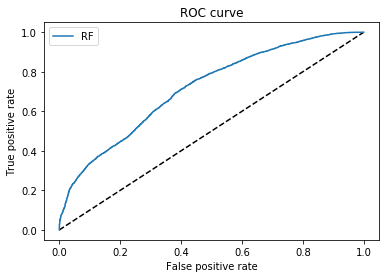

In [181]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Validation Metrics

              precision    recall  f1-score   support

           0       0.47      0.49      0.48      2332
           1       0.50      0.48      0.49      2450

    accuracy                           0.49      4782
   macro avg       0.49      0.49      0.49      4782
weighted avg       0.49      0.49      0.49      4782

Confusion Matrix
[[1148 1184]
 [1270 1180]]

Accuracy
0.4868255959849435


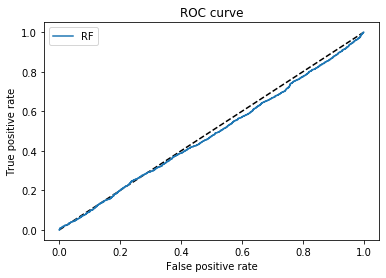

In [182]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [184]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2016-08-01 10:31:44.455000')
end = primary_forecast.index.get_loc('2017-12-29 21:03:37.018000') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

KeyError: '2016-08-01 10:31:44.455000'

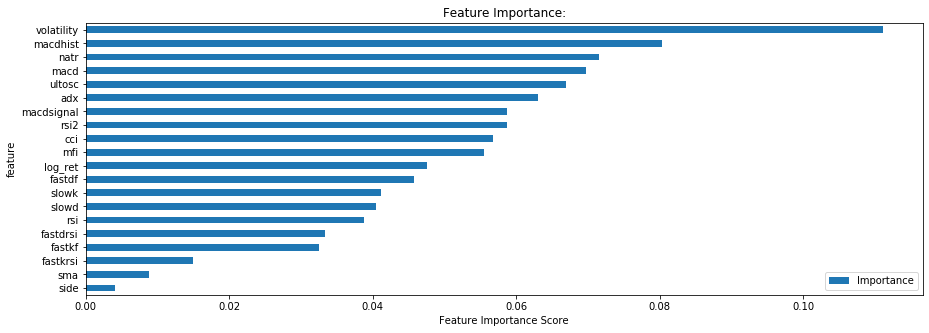

In [185]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheets (In-sample)

In [60]:
import pyfolio as pf

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [61]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [62]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [71]:


test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(primary_model_rets)
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)



TypeError: show_perf_stats() missing 1 required positional argument: 'factor_returns'

In [ ]:
#save the data as a new 

In [ ]:
.to_pickle